In [15]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy
from scipy.constants import hbar

π = np.pi
µs_to_ns = 1e3
norm_fact = 1/(np.sqrt(2))

# Test 6: Simuate $\sqrt{\mathrm{iSWAP}}$ (SQiSW) + Test Fidelity

## Reference: Nature Bialczak 2010

### States
$|g\rangle=(1,0,0)^T$, $|e\rangle=(0,1,0)^T$, $|f\rangle=(0,0,1)^T$, $|r_0\rangle=(1,0)^T$, $|r_1\rangle=(0,1)^T$

In [16]:
num_qubit_states = 3
num_res_states = 2

g_state = qt.basis(num_qubit_states, 0)
e_state = qt.basis(num_qubit_states, 1)
f_state = qt.basis(num_qubit_states, 2)

r0_state = qt.basis(num_res_states, 0)
r1_state = qt.basis(num_res_states, 1)

### Creation/Annihilation Operators: (qubit 1, qubit 2, resonator)
$b_1,b_1^\dagger, b_2, b_2^\dagger, c, c^\dagger.$ 

In [17]:
b1 = qt.tensor(qt.destroy(num_qubit_states), qt.qeye(num_qubit_states), qt.qeye(num_res_states))
b1dag = b1.dag() 
b2 = qt.tensor(qt.qeye(num_qubit_states), qt.destroy(num_qubit_states), qt.qeye(num_res_states))
b2dag = b2.dag() 
c = qt.tensor(qt.qeye(num_qubit_states), qt.qeye(num_qubit_states), qt.destroy(num_res_states))
cdag = c.dag()

### Projection Operators

In [18]:
gg0_proj = qt.tensor(g_state, g_state, r0_state).proj()
ge0_proj = qt.tensor(g_state, e_state, r0_state).proj()
gf0_proj = qt.tensor(g_state, f_state, r0_state).proj()

eg0_proj = qt.tensor(e_state, g_state, r0_state).proj()
ee0_proj = qt.tensor(e_state, e_state, r0_state).proj()
ef0_proj = qt.tensor(e_state, f_state, r0_state).proj()

fg0_proj = qt.tensor(f_state, g_state, r0_state).proj()
fe0_proj = qt.tensor(f_state, e_state, r0_state).proj()
ff0_proj = qt.tensor(f_state, f_state, r0_state).proj()

gg1_proj = qt.tensor(g_state, g_state, r1_state).proj()
ge1_proj = qt.tensor(g_state, e_state, r1_state).proj()
gf1_proj = qt.tensor(g_state, f_state, r1_state).proj()

eg1_proj = qt.tensor(e_state, g_state, r1_state).proj()
ee1_proj = qt.tensor(e_state, e_state, r1_state).proj()
ef1_proj = qt.tensor(e_state, f_state, r1_state).proj()

fg1_proj = qt.tensor(f_state, g_state, r1_state).proj()
fe1_proj = qt.tensor(f_state, e_state, r1_state).proj()
ff1_proj = qt.tensor(f_state, f_state, r1_state).proj()

### Hamiltonian
$H/\hbar = \sum_{i=1}^2{\left(\omega_i b_i^\dagger b_i + \frac{\alpha_i}{2} b_i^\dagger b_i^\dagger b_i b_i\right)} + (\omega_r+\chi_1 b_1^\dagger b_1+\chi_2 b_2^\dagger b_2)c^\dagger c + J(b_1^\dagger b_2+b_2^\dagger b_1+b_1^\dagger b_2^\dagger+b_1 b_2)$

In [19]:
def hamiltonian(omega_1, omega_2, omega_r, alpha_1, alpha_2, chi1, chi2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t3 = (omega_r + (chi1 * b1dag * b1) + (chi2 * b2dag * b2)) * cdag * c
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    t5 = J_coupling * (b1dag * b2dag + b1 * b2)
    return t1 + t2 + t3 + t4 + t5

### Plotting Functions

In [20]:
def plotresult(t_vec, time_evolution_b):
    ge0_pops = qt.expect(ge0_proj, time_evolution_b.states)
    eg0_pops = qt.expect(eg0_proj, time_evolution_b.states)
    gg0_pops = qt.expect(gg0_proj, time_evolution_b.states)
    ee0_pops = qt.expect(ee0_proj, time_evolution_b.states)
    
    ge1_pops = qt.expect(ge1_proj, time_evolution_b.states)
    eg1_pops = qt.expect(eg1_proj, time_evolution_b.states)
    gg1_pops = qt.expect(gg1_proj, time_evolution_b.states)
    ee1_pops = qt.expect(ee1_proj, time_evolution_b.states)
    
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(t_vec * µs_to_ns, ge0_pops, label="ge0")
    ax.plot(t_vec * µs_to_ns, eg0_pops, label="eg0")
    ax.plot(t_vec * µs_to_ns, gg0_pops, label="gg0")
    ax.plot(t_vec * µs_to_ns, ee0_pops, label="ee0")
    
    ax.plot(t_vec * µs_to_ns, ge1_pops, label="ge1")
    ax.plot(t_vec * µs_to_ns, eg1_pops, label="eg1")
    ax.plot(t_vec * µs_to_ns, gg1_pops, label="gg1")
    ax.plot(t_vec * µs_to_ns, ee1_pops, label="ee1")

    ax.legend()
    ax.set_xlabel('Time, $t$ [ns]')
    ax.set_ylabel(r'Amplitude Squared, $P_{mn}$')
    ax.set_title(r'$\sqrt{\mathrm{iSWAP}}$ gate')

    plt.show()
    plt.close()
    
def jointplot(t_vec, te0, te1, te2, te3):
    ge0_0_pops = qt.expect(ge0_proj, te0.states)
    eg0_0_pops = qt.expect(eg0_proj, te0.states)
    
    ge0_1_pops = qt.expect(ge0_proj, te1.states)
    eg0_1_pops = qt.expect(eg0_proj, te1.states)
    
    gg0_2_pops = qt.expect(gg0_proj, te2.states)
    
    #issues with ee - fg/gf swaps
    ee0_3_pops = qt.expect(ee0_proj, te3.states)
    gf0_3_pops = qt.expect(gf0_proj, te3.states)
    fg0_3_pops = qt.expect(fg0_proj, te3.states)
    
    fig, ax = plt.subplots(tight_layout=True)
    #ax.plot(t_vec * µs_to_ns, ge0_0_pops, label="ge0_0")
    ax.plot(t_vec * µs_to_ns, eg0_0_pops, label="eg0_0")
    
    #ax.plot(t_vec * µs_to_ns, ge0_1_pops, label="ge0_1")
    ax.plot(t_vec * µs_to_ns, eg0_1_pops, label="eg0_1")
    
    ax.plot(t_vec * µs_to_ns, gg0_2_pops, label="gg0_2")
    ax.plot(t_vec * µs_to_ns, ee0_3_pops, label="ee0_3")
    
    ax.plot(t_vec * µs_to_ns, gg0_2_pops, label="gg0_2")
    ax.plot(t_vec * µs_to_ns, ee0_3_pops, label="ee0_3")
    ax.plot(t_vec * µs_to_ns, fg0_3_pops, label="fg0_3")
    ax.plot(t_vec * µs_to_ns, gf0_3_pops, label="gf0_3")
    
    #issues with ee case
    fig1, ax1 = plt.subplots(tight_layout=True)
    ef0_3_pops = qt.expect(ef0_proj, te3.states)
    fe0_3_pops = qt.expect(fe0_proj, te3.states)
    ff0_3_pops = qt.expect(ff0_proj, te3.states)
    ax1.plot(t_vec * µs_to_ns, gf0_3_pops, label="gf0_3")
    ax1.plot(t_vec * µs_to_ns, fg0_3_pops, label="fg0_3")
    ax1.plot(t_vec * µs_to_ns, ef0_3_pops, label="ef0_3")
    ax1.plot(t_vec * µs_to_ns, fe0_3_pops, label="fe0_3")
    ax1.plot(t_vec * µs_to_ns, ff0_3_pops, label="ff0_3")
    ax1.legend()

    
    ax.legend()
    ax.set_xlabel('Time, $t$ [ns]')
    ax.set_ylabel(r'Amplitude Squared, $P_{mn}$')
    ax.set_title(r'$\sqrt{\mathrm{iSWAP}}$ gate')

### Initial Timescale Parameters

In [21]:
J_coupling = 2*π * 8
t_start = 0
t_end = 6 * π/(4*J_coupling) #π/4J ~ reach maximally entangled state (Jt = π/4)
t_vec = np.linspace(t_start, t_end, 601)

## On Resonance Case

### First Determine Gatelength

0.5078519903687032 0.49999831693014374 0.4921446762519457
100
15.625


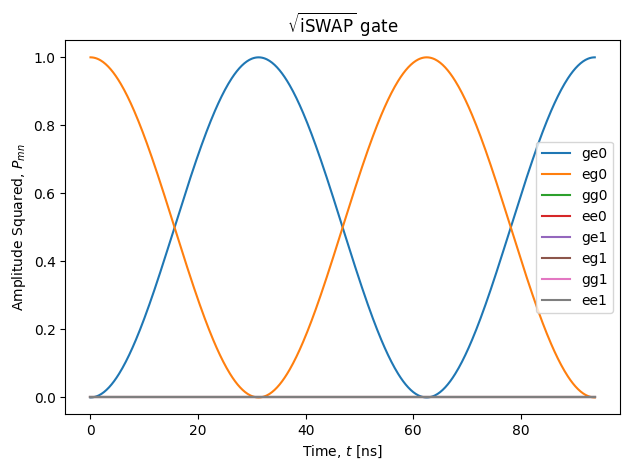

0.0


In [22]:
omega1 = 2*π * 6000
omega2 = 2*π * 6000
omegares = 2*π * 8000
alpha = 2*π * -300
chi = 2*π* 3 #(3mhz)

h = hamiltonian(omega_1=omega1, omega_2=omega2, omega_r=omegares, 
                alpha_1=alpha, alpha_2=alpha, chi1=chi, chi2=chi, 
                J_coupling=J_coupling)

psi0 = qt.tensor(e_state, g_state, r0_state)
te = qt.mesolve(h, psi0, t_vec, [], [])

eg0_pops = qt.expect(eg0_proj, te.states)
#argument of value closest to 0.5
argmin = np.argmin(np.abs(eg0_pops-0.5)[1:]) + 1
newt_end = t_vec[argmin]
newt_vec = np.linspace(t_start, newt_end, 601)

print(eg0_pops[argmin-1], eg0_pops[argmin],eg0_pops[argmin+1])
print(argmin)
print(t_vec[argmin] * µs_to_ns)
plotresult(t_vec, te)

#note in 2010 Nature Paper Bialczak g/2 = J
#SQiSW ==> gt = π/2, Jt = π/4
print(J_coupling * newt_vec[-1] - π/4)

In [51]:
eig, eigstates = h.eigenstates()
obj = np.array(eigstates[0]), np.array(eigstates[1]), np.array(eigstates[2]), np.array(eigstates[3])

In [52]:
len(eigstates)

18

In [49]:
from qutip import Qobj
qt.Qobj.column_stack

AttributeError: type object 'Qobj' has no attribute 'column_stack'

In [40]:
eigstates[0], eigstates[1]

(Quantum object: dims = [[3, 3, 2], [1, 1, 1]], shape = (18, 1), type = ket
 Qobj data =
 [[ 9.99999778e-01]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 6.44656794e-07]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [-6.66668046e-04]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 6.44656794e-07]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 4.55841295e-07]
  [ 0.00000000e+00]],
 Quantum object: dims = [[3, 3, 2], [1, 1, 1]], shape = (18, 1), type = ket
 Qobj data =
 [[ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 7.07106450e-01]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [-7.07106450e-01]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [-6.84227571e-04]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 6.84227571e-04]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [ 0.00000000e+00]])

In [28]:
eigstates

array([Quantum object: dims = [[3, 3, 2], [1, 1, 1]], shape = (18, 1), type = ket
       Qobj data =
       [[ 9.99999778e-01]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 6.44656794e-07]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [-6.66668046e-04]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 6.44656794e-07]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 4.55841295e-07]
        [ 0.00000000e+00]]                                                       ,
       Quantum object: dims = [[3, 3, 2], [1, 1, 1]], shape = (18, 1), type = ket
       Qobj data =
       [[ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 7.07106450e-01]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [-7.07106450e-01]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [ 0.00000000e+00]
        [-6.8

### Calculate Phase Function

In [ ]:
def calculatephase(psi, te):
    initial_state = te.states[0]
    final_state = te.states[-1]
    initial_phase = np.angle(psi.dag()*initial_state)[0][0]
    final_phase = np.angle(psi.dag()*final_state)[0][0]
    total_phase = final_phase - initial_phase
    return total_phase

## Test 1
###  Apply $\sqrt{\mathrm{iSwap}}$ Gate to $|e, g\rangle, |g, e\rangle, |g, g\rangle, |e, e\rangle$ and Compute Conditional Phases

In [ ]:
psi0 = qt.tensor(e_state, g_state, r0_state)
psi1 = qt.tensor(g_state, e_state, r0_state)
psi2 = qt.tensor(g_state, g_state, r0_state)
psi3 = qt.tensor(e_state, e_state, r0_state)

te0 = qt.mesolve(h, psi0, newt_vec, [], [])
te1 = qt.mesolve(h, psi1, newt_vec, [], [])
te2 = qt.mesolve(h, psi2, newt_vec, [], [])
te3 = qt.mesolve(h, psi3, newt_vec, [], [])

phase0 = calculatephase(psi0, te0)
phase1 = calculatephase(psi1, te1)
phase2 = calculatephase(psi2, te2)
phase3 = calculatephase(psi3, te3)

print(phase0, phase1, phase2, phase3)
jointplot(newt_vec, te0, te1, te2, te3)
plotresult(newt_vec, te0)

In [ ]:
def generate_state(a, phi_1, b, phi_2, c, phi_3): #phi1 ~
    psi0 = qt.tensor(g_state, g_state, r0_state)
    psi1 = qt.tensor(g_state, g_state, r1_state)
    psi2 = qt.tensor(g_state, e_state, r0_state)
    psi3 = qt.tensor(g_state, e_state, r1_state)
    psi4 = qt.tensor(g_state, f_state, r0_state)
    psi5 = qt.tensor(g_state, f_state, r1_state)
    psi6 = qt.tensor(e_state, g_state, r0_state)
    psi7 = qt.tensor(e_state, g_state, r1_state)
    psi8 = qt.tensor(e_state, e_state, r0_state)
    psi9 = qt.tensor(e_state, e_state, r1_state)
    psi10 = qt.tensor(e_state, f_state, r0_state)
    psi11 = qt.tensor(e_state, f_state, r1_state)
    psi12 = qt.tensor(f_state, g_state, r0_state)
    psi13 = qt.tensor(f_state, g_state, r1_state)
    psi14 = qt.tensor(f_state, e_state, r0_state)
    psi15 = qt.tensor(f_state, e_state, r1_state)
    psi16 = qt.tensor(f_state, f_state, r0_state)
    psi17 = qt.tensor(f_state, f_state, r1_state)
    
    return (a * (psi2 * np.exp(1j*phi_1))
            + b * (psi6 * np.exp(1j*phi_2))
            + c * (psi8 * np.exp(1j*phi_3))
           )

In [ ]:
def unitary_operator(phi_1, phi_2, phi_3): #phi1 ~
    return (
        qt.tensor(g_state, g_state, r0_state).proj() * 1
        + qt.tensor(g_state, g_state, r1_state).proj() * 1
        + qt.tensor(g_state, e_state, r0_state).proj() * np.exp(1j*phi_1)
        + qt.tensor(g_state, e_state, r1_state).proj() * 1
        + qt.tensor(g_state, f_state, r0_state).proj() * 1
        + qt.tensor(g_state, f_state, r1_state).proj() * 1
        + qt.tensor(e_state, g_state, r0_state).proj() * np.exp(1j*phi_2)
        + qt.tensor(e_state, g_state, r1_state).proj() * 1
        + qt.tensor(e_state, e_state, r0_state).proj() * np.exp(1j*phi_3)
        + qt.tensor(e_state, e_state, r1_state).proj() * 1
        + qt.tensor(e_state, f_state, r0_state).proj() * 1
        + qt.tensor(e_state, f_state, r1_state).proj() * 1
        + qt.tensor(f_state, g_state, r0_state).proj() * 1
        + qt.tensor(f_state, g_state, r1_state).proj() * 1
        + qt.tensor(f_state, e_state, r0_state).proj() * 1
        + qt.tensor(f_state, e_state, r1_state).proj() * 1
        + qt.tensor(f_state, f_state, r0_state).proj() * 1
        + qt.tensor(f_state, f_state, r1_state).proj() * 1
    )

In [ ]:
print(unitary_operator(π, 0, 0) * psi1)

$|\psi_0\rangle=(e,g,0)^T, |\psi_f\rangle=(g,e,0)^T$ with 180˚ phase

In [ ]:
#te0_f: ge with a picked up 180˚ phase
#te1_f: be eg with picked up 180˚ phase
theoretical_state_1_0 = generate_state(1, π, 0, 0, 0, 0)  #(e^iπ = -1)
theoretical_state_1_1 = (unitary_operator(π, 0, 0) * psi1)
print(theoretical_state_1_0 == theoretical_state_1_1)
print(f'Fidelity = {qt.fidelity(theoretical_state_1_0, te0.states[-1])}')
print(f'Phase = {calculatephase(psi0, te0)}')
print(f'Phase = {calculatephase(psi1, te1)}')
print(f'Phase = {calculatephase(psi2, te2)}')
print(f'Phase = {calculatephase(psi3, te3)}')

In [ ]:
te3.states[-1]

qt.propogator(te3)

### I imagine: 
1: Some set of physical initial conditions <br>
2: Symmetrical distribution (normal makes sense) of detunings centered on perfectly resonant <br>
3: Some distribution of gate times centered on the theoretical gatetime <br>
(Chevron potential when color plotted with output population) <br>
4: Set of initial states very close to the ideal states $|e, g\rangle, |g, e\rangle, |g, g\rangle, |e, e\rangle$ (maybe some parameter describing this spread)  ... (maybe separate readout fidelity into a different step), if not then like 2010 paper set of distinct input states     <br>
5: Evolve all of these cases, construct physical density matrix representing output state, compare them to the theoretical unitary operator operating on initial state that corresponds to the gate time / detuning, compute how similar these quantum states are via fidelity (intuition: a dot product between two state vectors)
6: Mean and std of fidelity <br>
7: T1, T2 decay impact (main error mechanism described in paper after inverting measurement fidelity, measurement cross-talk)

Is this sufficient in understanding in order to predict the reliability of a process? All of this doesn't feel convincing enough to me, there has to be a better way of understanding this process...

## Do not delete- Basis Representation Reminder

In [ ]:
psi0 = qt.tensor(g_state, g_state, r0_state)
psi1 = qt.tensor(g_state, g_state, r1_state)
psi2 = qt.tensor(g_state, e_state, r0_state)
psi3 = qt.tensor(g_state, e_state, r1_state)
psi4 = qt.tensor(g_state, f_state, r0_state)
psi5 = qt.tensor(g_state, f_state, r1_state)
psi6 = qt.tensor(e_state, g_state, r0_state)
psi7 = qt.tensor(e_state, g_state, r1_state)
psi8 = qt.tensor(e_state, e_state, r0_state)
psi9 = qt.tensor(e_state, e_state, r1_state)
psi10 = qt.tensor(e_state, f_state, r0_state)
psi11 = qt.tensor(e_state, f_state, r1_state)
psi12 = qt.tensor(f_state, g_state, r0_state)
psi13 = qt.tensor(f_state, g_state, r1_state)
psi14 = qt.tensor(f_state, e_state, r0_state)
psi15 = qt.tensor(f_state, e_state, r1_state)
psi16 = qt.tensor(f_state, f_state, r0_state)
psi17 = qt.tensor(f_state, f_state, r1_state)

print(psi0[0], psi1[1], psi2[2], psi3[3], psi4[4], psi5[5], 
      psi6[6], psi7[7], psi8[8], psi9[9], psi10[10], psi11[11], 
      psi12[12], psi13[13], psi14[14], psi15[15], psi16[16], psi17[17])

Note: fsim gate - both iSWAP (90˚) and conditional phase on 11 (30˚) within the same gate sequence 

Questions:
1. Theoretical unitary for fsim, iswap gates (in order to compute fidelity for simualted gate) typically written in the (0,0)(1,0)(0,1)(1,1) basis. Need to transform this gate into the basis im using.
    i. final choice of basis
    
2. Research direction-- wide variety of gates (cross resonance, sqisw, cphase, fsim) or in depth look at a specific gate, very much left to do with just SQiSW -- ideally get real data, problems seem to be entirely constrained to the system at hand, benchmarking strategy used, callibration locations